In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns

from IPython.display import display
from sklearn.svm import LinearSVR, SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

## Load codebook
The codebook will be used to determine column types, so we'll be able to convert them properly.

In [2]:
codebook = pd.read_excel(
    'recs2009_public_codebook.xlsx', header=1, skipfooter=5)
codebook = codebook[1:] # drop a column that is full of NaNs
codebook['Variable Name'] = codebook['Variable Name'].str.strip()
display(codebook)

# create a version with column names of dataset as index
codebook_reindexed = codebook.set_index('Variable Name')
codebook_reindexed.rename(columns={
    'Response Codes and Labels': 'Response Codes',
    'Unnamed: 3': 'Labels',
}, inplace=True, errors='raise')

,Variable Name,Variable Description,Response Codes and Labels,Unnamed: 3,Variables in End-Use Models (see note at bottom),Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
1,DOEID,Unique identifier for each respondent,00001 - 12083,Unique identifier for each respondent,NaN,NaN,NaN,NaN,NaN
2,REGIONC,Census Region,1\n2\n3\n4,Northeast Census Region\nMidwest Census Region...,NaN,NaN,NaN,NaN,NaN
3,DIVISION,Census Division,1\n2\n3\n4\n5\n6\n7\n8\n9\n10,"New England Census Division (CT, MA, ME, NH, R...",NaN,NaN,NaN,NaN,NaN
4,REPORTABLE_DOMAIN,Reportable states and groups of states,1\n2\n3\n4\n5\n6\n7\n8\n9\n10\n11\n12\n13\n14\...,"\nConnecticut, Maine, New Hampshire, Rhode Isl...",NaN,NaN,NaN,NaN,NaN
5,TYPEHUQ,Type of housing unit,1\n2\n3\n4\n5,Mobile Home\nSingle-Family Detached\nSingle-Fa...,OTH_B,SPH_A,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
936,WSF,Weather & shielding factor for the housing unit,NaN,Weather & shielding factor for the housing uni...,NaN,NaN,NaN,NaN,NaN
937,OA_LAT,Annual value for latent heat infiltration from...,NaN,Annual value for latent heat infiltration from...,NaN,NaN,NaN,NaN,NaN
938,GWT,Annual average ground water temperature (F) fo...,NaN,Annual average ground water temperature (F) fo...,NaN,NaN,NaN,NaN,NaN
939,DesignDBT99,Dry bulb design temperature (F) expected to be...,NaN,Dry bulb design temperature (F) expected to be...,NaN,NaN,NaN,NaN,NaN


### Retrieve column types from codebook

In [3]:
response_codes = codebook['Response Codes and Labels']

# extract imputation columns
# --> column names starting with a `Z`
imputation = codebook[codebook['Variable Name'].str.startswith('Z')]
imputation = imputation['Variable Name'].tolist()

# extract numerical columns
# --> response code column is either empty or a range of values (contains ` - `)
numerical = codebook[response_codes.str.contains(' - ', na=True)]
numerical = numerical['Variable Name'].tolist()

# extract boolean columns
boolean = codebook[response_codes.isin(['0\n1', '0\n1\n-2'])]
boolean = boolean[~boolean['Variable Name'].isin(imputation)]
boolean = boolean['Variable Name'].tolist()

# extract categorical columns
categorical = codebook[response_codes.str.contains('\n', na=False)]
categorical = categorical[~categorical['Variable Name'].isin(imputation)]
categorical = categorical[~categorical['Variable Name'].isin(numerical)]
categorical = categorical[~categorical['Variable Name'].isin(boolean)]
categorical = categorical['Variable Name'].tolist()

# print column counts per category
print('Numerical columns:\t', len(numerical))
print('Boolean columns:\t', len(boolean))
print('Categorical columns:\t', len(categorical))
print('Imputation columns:\t', len(imputation))
print('-' * 30)

col_cnt = sum(map(len, [numerical, boolean, categorical, imputation]))
print('Number of columns:\t', col_cnt)

# check that we didn't miss columns or have duplicates
assert col_cnt == len(codebook)
print('\nNumbers do add up!')

Numerical columns:	 149
Boolean columns:	 196
Categorical columns:	 236
Imputation columns:	 359
------------------------------
Number of columns:	 940

Numbers do add up!


## Load data from CSV

In [4]:
df = pd.read_csv('recs2009_public.csv', low_memory=False)

# -2 means `Not Applicable`
df = df.replace({-2: None})

# 77 means `Not Sure` and not one unit more than 76
df['NKRGALNC'] = df['NKRGALNC'].replace({77: None})

df

,DOEID,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,...,SCALEKER,IECC_Climate_Pub,HDD50,CDD80,GND_HDD65,WSF,OA_LAT,GWT,DesignDBT99,DesignDBT1
0,1,2,4,12,2,2471.68,4742,1080,4953,1271,...,None,4A,2117,56,4250,0.48,6,56,9,96
1,2,4,10,26,2,8599.17,2662,199,2688,143,...,None,3C,62,26,2393,0.61,0,64,38,73
2,3,1,1,1,5,8969.92,6233,505,5741,829,...,None,5A,2346,49,5654,0.48,3,52,12,88
3,4,2,3,7,2,18003.64,6034,672,5781,868,...,None,5A,2746,0,4941,0.55,4,55,7,87
4,5,1,1,1,3,5999.61,5388,702,5313,797,...,None,5A,2251,0,5426,0.61,4,50,13,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12078,12079,2,3,9,2,10219.80,7671,332,7784,451,...,None,6A-6B,4289,39,7819,0.59,0,48,-3,84
12079,12080,3,7,21,4,8689.07,2085,2844,2520,2286,...,None,3B-4B,360,393,1869,0.50,0,56,26,101
12080,12081,2,4,10,2,4697.21,7935,472,8074,600,...,None,6A-6B,4494,22,8477,0.58,1,46,-9,89
12081,12082,4,8,23,2,13155.68,5834,770,5989,957,...,None,5B-5C,2840,0,9010,0.54,1,53,13,93


### Drop imputation indicator columns and convert dtypes
Imputation indicators indicate if a column value has been infered due to "Don't Know" and "Refuse" responses in the survey.

In [5]:
# drop imputation columns
df.drop(columns=imputation, inplace=True)

# convert numerical columns
df[numerical] = df[numerical].replace({'.': None}) # to fix two entries
df[numerical] = df[numerical].apply(pd.to_numeric)

# convert boolean columns
df[boolean] = df[boolean].astype('bool')

# convert categorical columns
df[categorical] = df[categorical].astype('category')

df.dtypes

DOEID                   int64
REGIONC              category
DIVISION             category
REPORTABLE_DOMAIN    category
TYPEHUQ              category
                       ...   
WSF                   float64
OA_LAT                  int64
GWT                     int64
DesignDBT99           float64
DesignDBT1              int64
Length: 581, dtype: object

In [6]:
# split categorical variables
df = pd.get_dummies(df, dtype=bool)
df.shape

(12083, 1510)

In [7]:
df.describe()

,DOEID,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,YEARMADE,NUMFLRS,NUMAPTS,NAPTFLRS,...,TOTALDOLRFG,TOTALDOLOTH,HDD50,CDD80,GND_HDD65,WSF,OA_LAT,GWT,DesignDBT99,DesignDBT1
count,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,1923.000000,1923.000000,2849.000000,...,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12012.000000,12083.000000
mean,6042.000000,9402.981870,4141.375238,1415.406108,4135.146983,1443.503104,1971.062402,3.864275,38.758710,1.097578,...,154.143921,840.080692,1681.961764,139.568485,3763.728544,0.499036,5.656046,59.128693,20.387862,90.359431
std,3488.205986,5192.101419,2317.759375,1134.659475,2260.543686,1021.748722,24.817912,4.378762,64.291399,0.312920,...,106.281487,608.105246,1401.079218,264.186908,2597.754419,0.083520,6.797205,8.678293,15.286855,6.166669
min,1.000000,476.100000,0.000000,0.000000,0.000000,0.000000,1920.000000,1.000000,5.000000,1.000000,...,0.000000,3.000000,0.000000,0.000000,0.000000,0.310000,0.000000,36.000000,-23.000000,60.000000
25%,3021.500000,6297.040000,2197.500000,561.000000,2224.000000,712.000000,1955.000000,2.000000,8.000000,1.000000,...,86.000000,441.500000,262.500000,4.000000,1246.500000,0.430000,1.000000,52.000000,9.000000,87.000000
50%,6042.000000,7970.630000,4483.000000,1045.000000,4502.000000,1179.000000,1975.000000,3.000000,12.000000,1.000000,...,127.000000,713.000000,1684.000000,30.000000,3878.000000,0.500000,3.000000,58.000000,18.000000,90.000000
75%,9062.500000,11330.030000,5913.000000,1897.000000,5854.000000,1842.500000,1991.000000,3.000000,36.000000,1.000000,...,192.000000,1070.000000,2662.000000,117.000000,5834.000000,0.560000,7.000000,66.000000,33.000000,94.000000
max,12083.000000,95779.140000,12525.000000,5480.000000,13346.000000,5357.000000,2009.000000,35.000000,365.000000,3.000000,...,2490.000000,12826.000000,7623.000000,1884.000000,11567.000000,0.800000,34.000000,89.000000,67.000000,118.000000


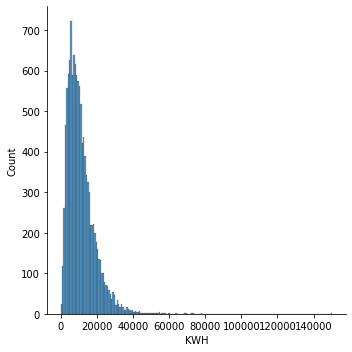

In [8]:
sns.displot(df['KWH'])

### Drop NaN/None values

In [9]:
df_cleaned = df[df.columns[~df.isna().any()]]
df_cleaned

,DOEID,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,YEARMADE,ORIG1FAM,STUDIO,TYPEHUQ4,...,IECC_Climate_Pub_2B,IECC_Climate_Pub_3A,IECC_Climate_Pub_3B-4B,IECC_Climate_Pub_3C,IECC_Climate_Pub_4A,IECC_Climate_Pub_4C,IECC_Climate_Pub_5A,IECC_Climate_Pub_5B-5C,IECC_Climate_Pub_6A-6B,IECC_Climate_Pub_7A-7B-7AK-8AK
0,1,2471.68,4742,1080,4953,1271,2004,False,False,False,...,False,False,False,False,True,False,False,False,False,False
1,2,8599.17,2662,199,2688,143,1998,False,False,False,...,False,False,False,True,False,False,False,False,False,False
2,3,8969.92,6233,505,5741,829,1965,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,4,18003.64,6034,672,5781,868,1985,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,5,5999.61,5388,702,5313,797,1983,False,False,False,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12078,12079,10219.80,7671,332,7784,451,1985,False,False,False,...,False,False,False,False,False,False,False,False,True,False
12079,12080,8689.07,2085,2844,2520,2286,1980,False,True,False,...,False,False,True,False,False,False,False,False,False,False
12080,12081,4697.21,7935,472,8074,600,1993,False,False,False,...,False,False,False,False,False,False,False,False,True,False
12081,12082,13155.68,5834,770,5989,957,1930,False,False,False,...,False,False,False,False,False,False,False,True,False,False


## Compute some correlations

### Extract types of energy for future analysis

In [10]:
columns = codebook['Variable Name'].tolist()

energy_types = []
for suffix in ('AUX', 'WARM'):
    energy_types.extend([col[:-len(suffix)] for col in columns
                          if col.endswith(suffix)])
    
energy_types.sort()
print(energy_types)

# `EQUIP` here is not an energy type, so we drop it
energy_types.remove('EQUIP')
print(energy_types)

['EL', 'ELEC', 'EQUIP', 'FO', 'FOIL', 'KERO', 'KR', 'LP', 'LPG', 'OTH', 'OTHER', 'SOL', 'SOLAR', 'UG', 'UGAS', 'WD', 'WOOD']
['EL', 'ELEC', 'FO', 'FOIL', 'KERO', 'KR', 'LP', 'LPG', 'OTH', 'OTHER', 'SOL', 'SOLAR', 'UG', 'UGAS', 'WD', 'WOOD']


In [11]:
def dataframize(series, col_name):
    dataframe = series.to_frame()
    dataframe.columns.values[0] = col_name
        
    descriptions = [codebook_reindexed.loc[col, 'Variable Description'] for col in dataframe.index]
    dataframe['Description'] = descriptions
    
    return dataframe   

In [12]:
def plot_kwh_corr_for_col_type(dataframe, prefix=None, suffix=None, startswith=None):
    nrg_types = '|'.join(energy_types)
    
    col_selector = ''
    if prefix:
        col_selector = f"{prefix}({nrg_types})"
    elif suffix:
        col_selector = f"({nrg_types}){suffix}"
    elif startswith:
        col_selector = f"{startswith}.*"
        
    
    pattern = f"^({col_selector}|KWH)$"
    
    filtered_df = dataframe.filter(regex=pattern)
    
    corr = filtered_df.corr()
    corr = corr.sort_values(by='KWH', ascending=False, axis=0)
    corr = corr.sort_values(by='KWH', ascending=False, axis=1)
    
    kwh_corr = dataframize(corr['KWH'], 'KWH Corr')
    with pd.option_context('display.max_colwidth', None):
        display(kwh_corr)
    
    sns.heatmap(
        corr,
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        annot=True,
        cmap=sns.diverging_palette(220, 20, as_cmap=True),
    )
    
    plt.show()
    
    return kwh_corr

,KWH Corr,Description
KWH,1.000000,"Total Site Electricity usage, in kilowatt-hours, 2009"
USELP,0.218624,Propane is used in home
USEWOOD,0.112154,Wood is used in home
USEOTH,0.073753,Other fuel is used in home
USESOLAR,0.026743,Solar is used in home
USEKERO,-0.000217,Kerosene is used in home
USEFO,-0.087739,Fuel oil is used in home
USEEL,NaN,Electricity is used in home


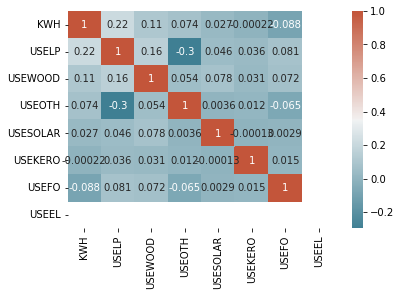

,KWH Corr,Description
KWH,1.000000,"Total Site Electricity usage, in kilowatt-hours, 2009"
ELWARM,0.289630,Electricity used for space heating
WDWARM,0.103575,Wood used for space heating
LPWARM,0.100349,Propane used for space heating
SOLWARM,0.003818,Solar used for space heating
KRWARM,-0.000709,Kerosene used for space heating
OTHWARM,-0.004176,Other fuel used for space heating
FOWARM,-0.085846,Fuel oil used for space heating
UGWARM,-0.236648,Natural gas used for space heating


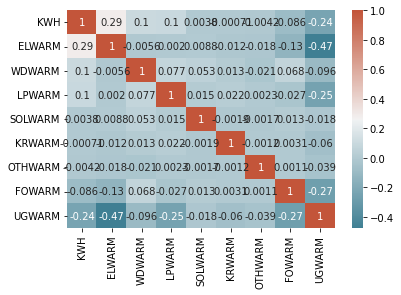

,KWH Corr,Description
KWH,1.000000,"Total Site Electricity usage, in kilowatt-hours, 2009"
LPGAUX,0.113943,Propane used for secondary space heating
WOODAUX,0.109307,Wood used for secondary space heating
ELECAUX,0.078795,Electricity used for secondary space heating
UGASAUX,0.059387,Natural gas used for secondary space heating
KEROAUX,0.018781,Kerosene used for secondary space heating
OTHERAUX,0.011722,Other fuel used for secondary space heating
SOLARAUX,0.003139,Solar used for secondary space heating
FOILAUX,-0.002442,Fuel oil used for secondary space heating


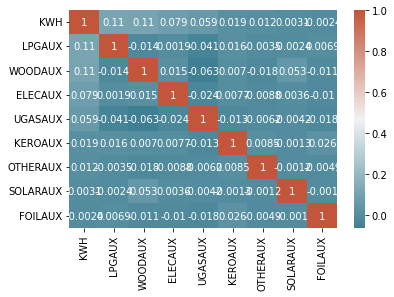

,KWH Corr,Description
KWH,1.000000,"Total Site Electricity usage, in kilowatt-hours, 2009"
ELWATER,0.341109,Electricity used for water heating
LPWATER,0.024049,Propane used for water heating
SOLWATER,0.004118,Solar used for water heating
WDWATER,-0.003867,Wood used for water heating
OTHWATER,-0.005382,Other fuel used for water heating
KRWATER,-0.011004,Kerosene used for water heating
FOWATER,-0.078480,Fuel oil used for water heating
UGWATER,-0.301663,Natural gas used for water heating


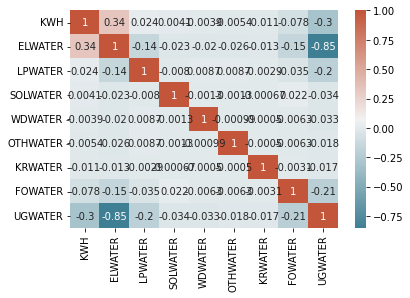

In [13]:
cols_of_interest = (
    {'prefix': 'USE'},
    {'suffix': 'WARM'},
    {'suffix': 'AUX'},
    {'suffix': 'WATER'},
)

results = []
for kwargs in cols_of_interest:
    kwh_corr = plot_kwh_corr_for_col_type(df_cleaned, **kwargs)
    results.append(kwh_corr)

In [14]:
threshold = 0.2

joined = pd.concat(results)
joined.drop('KWH', inplace=True)

# extract lines with correlation exceeding threshold
high_pos_effect = joined.loc[joined['KWH Corr'] >= threshold]
high_neg_effect = joined.loc[joined['KWH Corr'] <= -threshold]
    
with pd.option_context('display.max_colwidth', None):
    print('These are positively correlated with a higher consumption:')
    display(high_pos_effect)
    print()
    print()
    print('These are negatively correlated with a higher consumption:')
    display(high_neg_effect)

These are positively correlated with a higher consumption:


,KWH Corr,Description
USELP,0.218624,Propane is used in home
ELWARM,0.289630,Electricity used for space heating
ELWATER,0.341109,Electricity used for water heating




These are negatively correlated with a higher consumption:


,KWH Corr,Description
UGWARM,-0.236648,Natural gas used for space heating
UGWATER,-0.301663,Natural gas used for water heating


## Train models

In [15]:
def get_feats_and_target_cols(dataframe):
    target_col = 'KWH'
    feat_cols = [col for col in dataframe if col != target_col]
    return feat_cols, target_col

In [16]:
def get_train_valid_split(dataframe, valid_frac=0.15, random_state=2022, shuffle=True):
    valid_size = int(valid_frac * len(df_cleaned))

    if shuffle:
        dataframe = dataframe.sample(frac=1, random_state=random_state)
        
    valid, train = dataframe.iloc[:valid_size], dataframe.iloc[valid_size:]

    train_data, train_targets = train[feat_cols], train[target_col]
    valid_data, valid_targets = valid[feat_cols], valid[target_col]

    return train_data, train_targets, valid_data, valid_targets

In [17]:
def train_random_forest_reg(data, targets, *, n_estimators=None, max_depth=None):
    # model instantiation
    forest = RandomForestRegressor(
        random_state=42,
        n_estimators=n_estimators,
        max_depth=max_depth
    )
    
    # model training
    forest.fit(data, targets)
    
    # return trained model
    return forest

In [18]:
def train_knn_reg(data, targets, *, n_neighbors=None):
    # model instantiation
    knn_reg = KNeighborsRegressor(
        n_neighbors=n_neighbors,
    )
    
    # model training
    knn_reg.fit(data, targets)
    
    # return trained model
    return knn_reg

In [19]:
def plot_most_relevant_feats(forest, best_feat_cnt=25):
    """
        Thanks to:
            https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
    """
    feats_std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    
    forest_importances = pd.Series(forest.feature_importances_, index=feat_cols)
    forest_importances.sort_values(ascending=False, inplace=True)

    feats_std = feats_std[:best_feat_cnt]
    forest_importances = forest_importances.head(best_feat_cnt)

    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=feats_std, ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    
    plt.show()
    
    with pd.option_context('display.max_colwidth', None):
        display(add_feat_descriptions(forest_importances))

In [25]:
def add_feat_descriptions(series):
    dataframe = series.to_frame()
    
    descriptions, extra_infos = [], []
    for col_name in dataframe.index:
        if col_name in codebook_reindexed.index:
            descriptions.append(codebook_reindexed['Variable Description'].loc[col_name])
            extra_infos.append('')
        else:
            col, val = re.split(r'(?<=\w)_(?=\d+)', col_name)
            resp_codes = codebook_reindexed.loc[col, 'Response Codes'].split('\n')
            labels = codebook_reindexed.loc[col, 'Labels'].split('\n')
            trans_dict = dict(zip(resp_codes, labels))
            descriptions.append(codebook_reindexed['Variable Description'].loc[col])
            extra_infos.append(trans_dict[val])
            
    dataframe['Description'] = descriptions
    dataframe['Specification'] = extra_infos
    return dataframe

In [26]:
feat_cols, target_col = get_feats_and_target_cols(df_cleaned)

train_data, train_targets, valid_data, valid_targets = \
    get_train_valid_split(df_cleaned)

print('Train size:', len(train_data))
print('Valid size:', len(valid_data))

Train size: 10271
Valid size: 1812


In [27]:
n_estimators = 25
max_depth = 25

In [28]:
forest_all_feats = train_random_forest_reg(
    train_data, train_targets, n_estimators=n_estimators, max_depth=max_depth)

valid_preds = forest_all_feats.predict(valid_data)
mse = mean_squared_error(valid_targets, valid_preds)

print('Mean square error:', mse)

Mean square error: 23759.27650066222


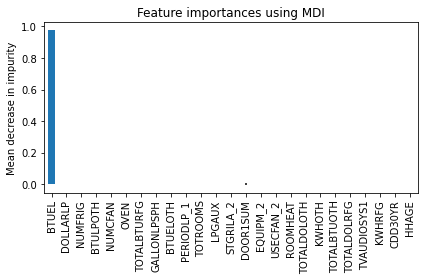

,0,Description,Specification
BTUEL,0.976582,"Total Site Electricity usage, in thousand BTU, 2009",
DOLLARLP,0.002511,"Total cost of LPG/Propane, in whole dollars, 2009",
NUMFRIG,0.002506,Number of refrigerators used,
BTULPOTH,0.002427,"LPG/Propane usage for other purposes (all end-uses except SPH and WTH), in thousand BTU, 2009",
NUMCFAN,0.002386,Number of ceiling fans used,
OVEN,0.001775,Number of separate ovens,
TOTALBTURFG,0.001718,"Total usage for refrigerators, in thousand BTU, 2009",
GALLONLPSPH,0.001698,"LPG/Propane usage for space heating, in gallons, 2009",
BTUELOTH,0.001263,"Electricity usage for other purposes (all end-uses except SPH, COL, WTH, and RFG), in thousand BTU, 2009",
PERIODLP_1,0.001082,Number of days covered by Energy Supplier Survey LPG/propane billing data and used to calculate annual consumption and expenditures,365 days (complete)


In [29]:
plot_most_relevant_feats(forest_all_feats)

### Restricting columns used to train the model

As can be demonstrated, a particular feature trivially indicates KWH consumption.

In fact, by removing all but one feature, we get lower mean squared error...

In [30]:
feat_cols = ['BTUEL']

train_data, train_targets, valid_data, valid_targets = \
    get_train_valid_split(df_cleaned)

forest_single_feat = train_random_forest_reg(
    train_data, train_targets, n_estimators=n_estimators, max_depth=max_depth)

valid_preds = forest_single_feat.predict(valid_data)
mse = mean_squared_error(valid_targets, valid_preds)

print('Mean square error:', mse)

Mean square error: 1435.311403090504


### Analysing columns that are too correlated with KWH consumption

,KWH Corr,Description
KWH,1.000000,"Total Site Electricity usage, in kilowatt-hours, 2009"
KWHOTH,0.880403,"Electricity usage for other purposes (all end-uses except SPH, COL, WTH, and RFG), in kilowatt-hours, 2009"
KWHCOL,0.655104,"Electricity usage for air-conditioning, central and window/wall (room), in kilowatt-hours, 2009"
KWHRFG,0.638621,"Electricity usage for refrigerators, in kilowatt-hours, 2009"
KWHWTH,0.585656,"Electricity usage for water heating, in kilowatt-hours, 2009"
KWHSPH,0.497684,"Electricity usage for space heating, in kilowatt-hours, 2009"


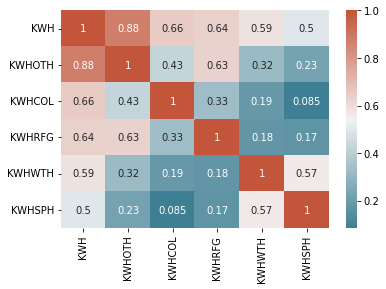

,KWH Corr,Description
KWH,1.000000,"Total Site Electricity usage, in kilowatt-hours, 2009"
BTUEL,1.000000,"Total Site Electricity usage, in thousand BTU, 2009"
BTUELOTH,0.880403,"Electricity usage for other purposes (all end-uses except SPH, COL, WTH, and RFG), in thousand BTU, 2009"
BTUELCOL,0.655104,"Electricity usage for air-conditioning, central and window/wall (room), in thousand BTU, 2009"
BTUELRFG,0.638621,"Electricity usage for refrigerators, in thousand BTU, 2009"
BTUELWTH,0.585656,"Electricity usage for water heating, in thousand BTU, 2009"
BTUELSPH,0.497684,"Electricity usage for space heating, in thousand BTU, 2009"
BTULPOTH,0.124123,"LPG/Propane usage for other purposes (all end-uses except SPH and WTH), in thousand BTU, 2009"
BTULP,0.120538,"Total LPG/LPG/Propane usage, in thousand BTU, 2009"
BTULPSPH,0.094568,"LPG/Propane usage for space heating, in thousand BTU, 2009"


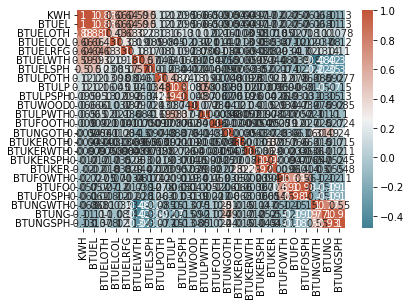

,KWH Corr,Description
KWH,1.000000,"Total Site Electricity usage, in kilowatt-hours, 2009"
GALLONLPOTH,0.124146,"LPG/Propane usage for other purposes (all end-uses except SPH and WTH), in gallons, 2009"
GALLONLP,0.120538,"Total LPG/Propane usage, in gallons, 2009"
GALLONLPSPH,0.094561,"LPG/Propane usage for space heating, in gallons, 2009"
GALLONLPWTH,0.065072,"LPG/Propane usage for water heating, in gallons, 2009"
GALLONFOOTH,0.008975,"Fuel Oil usage for other purposes (all end-uses except SPH and WTH), in gallons, 2009"
GALLONKEROTH,-0.009347,"Kerosene usage for other purposes (all end-uses except SPH and WTH), in gallons, 2009"
GALLONKERWTH,-0.009703,"Kerosene usage for water heating, in gallons, 2009"
GALLONKERSPH,-0.016950,"Kerosene usage for space heating, in gallons, 2009"
GALLONKER,-0.020422,"Total Kerosene usage, in gallons, 2009"


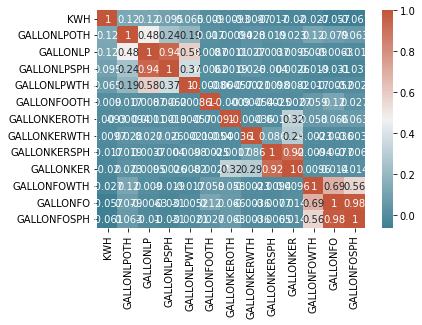

,KWH Corr,Description
KWH,1.000000,"Total Site Electricity usage, in kilowatt-hours, 2009"
DOLLAREL,0.868712,"Total Electricity cost, in whole dollars, 2009"
DOLELOTH,0.702251,"Electricity cost for other purposes (all end-uses except SPH, COL, WTH, and RFG), in wholedollars, 2009"
DOLELCOL,0.601626,"Electricity cost for air-conditioning, central and window/wall (room), in whole dollars, 2009"
DOLELWTH,0.514613,"Electricity cost for water heating, in whole dollars, 2009"
DOLELSPH,0.452504,"Electricity cost for space heating, in whole dollars, 2009"
DOLELRFG,0.433472,"Electricity cost for refrigerators, in whole dollars, 2009"
DOLLARLP,0.125628,"Total cost of LPG/Propane, in whole dollars, 2009"
DOLLPOTH,0.114359,"Cost of LPG/Propane for other purposes (all end-uses except SPH and WTH), in whole dollars, 2009"
DOLLPSPH,0.100672,"Cost of LPG/Propane for space heating, in whole dollars, 2009"


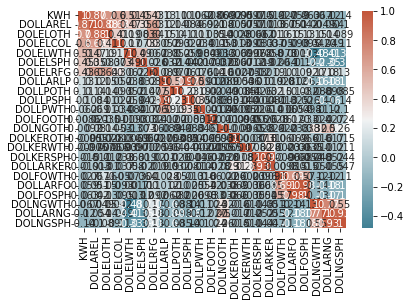

,KWH Corr,Description
KWH,1.000000,"Total Site Electricity usage, in kilowatt-hours, 2009"
TOTALBTUOTH,0.676108,"Total usage for appliances, electronics, lighting, and miscellaneous uses, in thousand BTU, 2009"
TOTALDOLOTH,0.655742,"Total cost for appliances, electronics, lighting, and miscellaneous uses, in whole dollars, 2009"
TOTALBTUCOL,0.655103,"Total usage for air conditioning, in thousand BTU, 2009"
TOTALBTURFG,0.638621,"Total usage for refrigerators, in thousand BTU, 2009"
TOTALDOL,0.627922,"Total cost, in whole dollars, 2009"
TOTALDOLCOL,0.601628,"Total cost for air conditioning, in whole dollars, 2009"
TOTALDOLWTH,0.437826,"Total cost for water heating, in whole dollars, 2009"
TOTALDOLRFG,0.433450,"Total cost for refrigerators, in whole dollars, 2009"
TOTALBTU,0.388949,"Total usage, in thousand BTU, 2009"


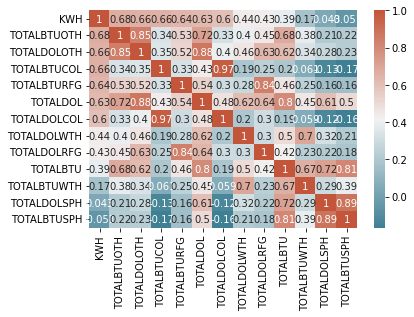

In [31]:
cols_of_interest = (
    {'startswith': 'KWH'},
    {'startswith': 'BTU'},
    {'startswith': 'GALLON'},
    {'startswith': 'DOL'},
    {'startswith': 'TOTAL'},
)

results = []
for kwargs in cols_of_interest:
    kwh_corr = plot_kwh_corr_for_col_type(df_cleaned, **kwargs)
    results.append(kwh_corr)

In [32]:
joined = pd.concat(results)
joined.drop('KWH', inplace=True)
joined = joined.sort_values(by='KWH Corr', ascending=False)

with pd.option_context('display.max_colwidth', None, 'display.max_rows', None):
    display(joined)

,KWH Corr,Description
BTUEL,1.000000,"Total Site Electricity usage, in thousand BTU, 2009"
BTUELOTH,0.880403,"Electricity usage for other purposes (all end-uses except SPH, COL, WTH, and RFG), in thousand BTU, 2009"
KWHOTH,0.880403,"Electricity usage for other purposes (all end-uses except SPH, COL, WTH, and RFG), in kilowatt-hours, 2009"
DOLLAREL,0.868712,"Total Electricity cost, in whole dollars, 2009"
DOLELOTH,0.702251,"Electricity cost for other purposes (all end-uses except SPH, COL, WTH, and RFG), in wholedollars, 2009"
TOTALBTUOTH,0.676108,"Total usage for appliances, electronics, lighting, and miscellaneous uses, in thousand BTU, 2009"
TOTALDOLOTH,0.655742,"Total cost for appliances, electronics, lighting, and miscellaneous uses, in whole dollars, 2009"
BTUELCOL,0.655104,"Electricity usage for air-conditioning, central and window/wall (room), in thousand BTU, 2009"
KWHCOL,0.655104,"Electricity usage for air-conditioning, central and window/wall (room), in kilowatt-hours, 2009"
TOTALBTUCOL,0.655103,"Total usage for air conditioning, in thousand BTU, 2009"


### Some personal notes regarding the above results

Columns having a correlation with KWH consumption over 0.38 are not very informative since they are all directly related to electricity cost or electricity usage for various high-consumption house appliances.

To get better insights, we'll try dropping these columns and train more models.

In [33]:
threshold = 0.38

# extract lines with correlation exceeding threshold
high_pos_effect = joined.loc[joined['KWH Corr'] >= threshold]

excluded_cols = high_pos_effect.index.tolist()
print(sorted(excluded_cols))

['BTUEL', 'BTUELCOL', 'BTUELOTH', 'BTUELRFG', 'BTUELSPH', 'BTUELWTH', 'DOLELCOL', 'DOLELOTH', 'DOLELRFG', 'DOLELSPH', 'DOLELWTH', 'DOLLAREL', 'KWHCOL', 'KWHOTH', 'KWHRFG', 'KWHSPH', 'KWHWTH', 'TOTALBTU', 'TOTALBTUCOL', 'TOTALBTUOTH', 'TOTALBTURFG', 'TOTALDOL', 'TOTALDOLCOL', 'TOTALDOLOTH', 'TOTALDOLRFG', 'TOTALDOLWTH']


### Training models with a restricted set of (hopefully) more informative features

In [34]:
# get back full set of feature columns
feat_cols, target_col = get_feats_and_target_cols(df_cleaned)

# excluded the columns that are too representative
excluded_cols = set(excluded_cols)
feat_cols = [col for col in feat_cols if col not in excluded_cols]

# get back train/valid splits, but using only non-excluded columns
train_data, train_targets, valid_data, valid_targets = \
    get_train_valid_split(df_cleaned)

Mean square error: 13869842.429877603


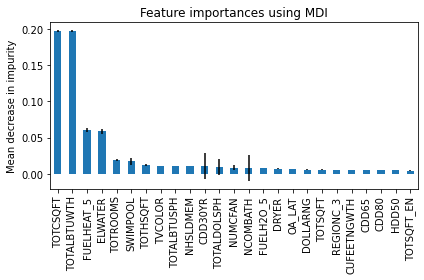

,0,Description,Specification
TOTCSQFT,0.197103,Total cooled square footage,
TOTALBTUWTH,0.196614,"Total usage for water heating, in thousand BTU, 2009",
FUELHEAT_5,0.060844,Main space heating fuel,Electricity
ELWATER,0.058598,Electricity used for water heating,
TOTROOMS,0.019238,Total number of rooms in the housing unit,
SWIMPOOL,0.017238,Swimming pool,
TOTHSQFT,0.012433,Total heated square footage,
TVCOLOR,0.011110,Number of televisions used,
TOTALBTUSPH,0.010914,"Total usage for space heating, in thousand BTU, 2009",
NHSLDMEM,0.010891,Number of household members,


In [35]:
forest_restricted_feats = train_random_forest_reg(
    train_data, train_targets, n_estimators=n_estimators, max_depth=max_depth)

valid_preds = forest_restricted_feats.predict(valid_data)
mse = mean_squared_error(valid_targets, valid_preds)

print('Mean square error:', mse)

plot_most_relevant_feats(forest_restricted_feats)

In [36]:
n_neighbors = 20
knn_restricted_feats = train_knn_reg(
    train_data, train_targets, n_neighbors=n_neighbors)

valid_preds = knn_restricted_feats.predict(valid_data)
mse = mean_squared_error(valid_targets, valid_preds)

print('Mean square error:', mse)

Mean square error: 27540424.659655076


In [ ]:
max_iter = 5000
linear_srv_restricted_feats = LinearSVR(max_iter=max_iter)
linear_srv_restricted_feats.fit(train_data, train_targets)

valid_preds = linear_srv_restricted_feats.predict(valid_data)
mse = mean_squared_error(valid_targets, valid_preds)

print('Mean square error:', mse)

In [ ]:
max_iter = 5000
srv_restricted_feats = SVR(max_iter=max_iter)
srv_restricted_feats.fit(train_data, train_targets)

valid_preds = srv_restricted_feats.predict(valid_data)
mse = mean_squared_error(valid_targets, valid_preds)

print('Mean square error:', mse)

In [37]:
gaus_process_restricted_feats = GaussianProcessRegressor()
gaus_process_restricted_feats.fit(train_data, train_targets)

valid_preds = gaus_process_restricted_feats.predict(valid_data)
mse = mean_squared_error(valid_targets, valid_preds)

print('Mean square error:', mse)

Mean square error: 172484990.54690948


In [38]:
# max_iter = 5000
mlp_restricted_feats = MLPRegressor()
mlp_restricted_feats.fit(train_data, train_targets)

valid_preds = mlp_restricted_feats.predict(valid_data)
mse = mean_squared_error(valid_targets, valid_preds)

print('Mean square error:', mse)

Mean square error: 15650628.216823371


# Conclusion

After a thorough look at the data, one of the first thing we understand is that the KWH consumption can be trivially recovered from a linear combination of other columns.

After removing these columns from our analysis, we can get some true insights about this dataset:

- Consumption is higher when the area of interest is larger and when there is more rooms.
- Consumption is higher when electricity is used for heating.
- Consumption is higher when there is a swimming pool. 

In [ ]:
TOTCSQFT	0.197103	Total cooled square footage	
TOTALBTUWTH	0.196614	Total usage for water heating, in thousand BTU, 2009	
FUELHEAT_5	0.060844	Main space heating fuel	Electricity
ELWATER	0.058598	Electricity used for water heating	
TOTROOMS	0.019238	Total number of rooms in the housing unit	
SWIMPOOL	0.017238	Swimming pool	
TOTHSQFT	0.012433	Total heated square footage	
TVCOLOR	0.011110	Number of televisions used	
TOTALBTUSPH	0.010914	Total usage for space heating, in thousand BTU, 2009	
NHSLDMEM	0.010891	Number of household members	
CDD30YR	0.010464	Cooling degree days, 30-year average 1981-2010, base 65F	
TOTALDOLSPH	0.009863	Total cost for space heating, in whole dollars, 2009	
NUMCFAN	0.008741	Number of ceiling fans used	